In [11]:
!pip install pandas_datareader
!pip install matplotlib
!pip install numpy
!pip install pandas

In [12]:
import pandas_datareader.data as pdr
import numpy as np
import datetime

In [13]:
# Download historical data for required stocks
ticker = "AAPL"
ohlcv = pdr.get_data_yahoo(ticker,datetime.date.today()-datetime.timedelta(364),datetime.date.today())

In [14]:
ohlcv.shape

(251, 6)

In [15]:
ohlcv.head(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-20,162.110001,155.300003,160.399994,156.830002,64773000.0,154.508499
2018-12-21,158.160004,149.630005,156.860001,150.729996,95744600.0,148.498795
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,144.656540
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,154.843475


In [16]:
ohlcv.tail(4)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,275.149994
2019-12-16,280.790009,276.980011,277.000000,279.859985,32046500.0,279.859985
2019-12-17,281.769989,278.799988,279.570007,280.410004,28539600.0,280.410004
2019-12-18,281.899994,279.119995,279.799988,279.739990,29007100.0,279.739990


In [17]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [18]:
def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/14) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/14) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/14) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

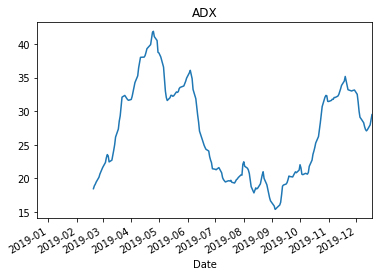

In [19]:
ADX(ohlcv,20).plot(title="ADX")